In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Tensorflow Probability: spatial patterns in genetics

This is using data generated in the `spatial_population_structure_genetic_simulations` notebook.

The model is based on the `vae.py` from the examples directory in the official tensorflow probability repo: https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/vae.py 


The function is a basic stack of fully connected layers that shrink in size as they go from the input dimension (large) to the latent dimension (small).

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from sklearn.model_selection import train_test_split

tfd = tf.contrib.distributions

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/tf_inspect.py:66: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  _inspect.getargspec(target))
/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/tf_inspect.py:66: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  _inspect.getargspec(target))
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [5]:
# simulation parameters copied from other notebook.
n = 10000 # individuals
m = 1000 # variants
d = 2 # latent dimension

# estiamtion routine parameters
batch_size = 100
epochs = 10

In [6]:
X = np.load('./data/spatial_a-0.1_N-'+ str(n) + '_M-' + str(m) +'.pandas.gz.npy')
X = X.astype(np.float32)


labels = np.load('./data/spatial_a-0.1_N-'+ str(n) + '_M-' + str(m) +'_labels.pandas.gz.npy')
labels = labels.astype(np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

## Basic VAE

We'll start with a basic, deep, variational autoencoder. Our goal is to try and recover something similar to our specified latent dimension. We will test out how models are specified in `tfp`!

This is more-or-less following the example given in the official repository: https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/vae.py

We start by defining our symmetric encoder/decoder networks.

In [16]:
def make_encoder(x, latent_dimension=2):
    x = tf.layers.dense(inputs=x,
            units=512, activation=tf.nn.relu)
    x = tf.layers.dense(inputs=x,
            units=256, activation=tf.nn.relu)
    x = tf.layers.dense(inputs=x,
            units=128, activation=tf.nn.relu)
    encoder_net = tf.layers.dense(inputs=x,
                      units = latent_dimension * 2,
                      activation=None)
    
    loc = encoder_net[..., :latent_dimension]
    scale = tf.nn.softplus(encoder_net[..., latent_dimension:] + 0.5)

    return tfd.MultivariateNormalDiag(loc=loc,
            scale_diag=scale,
            name="encoder_distribution")
    

def make_decoder(z, num_features=m, latent_dimension=2):
    z = tf.reshape(z, [-1, batch_size, latent_dimension])
    x = tf.layers.dense(inputs=latent_code,
            units=128, activation=tf.nn.relu)
    x = tf.layers.dense(inputs=x,
             units=256, activation=tf.nn.relu)
    x = tf.layers.dense(inputs=x,
            units=512, activation=tf.nn.relu)
    
    decoder_net = tf.layers.dense(inputs=x,
            units=num_features, activation=None)    
    
    return tfd.Independent(tfd.Binomial(logits=decoder_net,
                            total_count=2.0),
                            reinterpreted_batch_ndims=1,
                            name="decoder_distribution")

def make_prior(latent_dimension):
    prior =  tfd.MultivariateNormalDiag(scale_diag=tf.ones(latent_dimension),
                                    name="prior_distribution")
    return prior


We can then build our input pipeline, VAE model and inference steps.

In [136]:
graph = tf.Graph()
with graph.as_default():
    # input pipeline
    dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    dataset = dataset.batch(batch_size)
    iterator = dataset.make_initializable_iterator()
    (data, labels) = iterator.get_next()
    
    # inference network; encoder
    with tf.variable_scope('encoder'):
        encoder = make_encoder(data, latent_dimension=d)
    
    z = encoder.sample()

    # prior
    with tf.variable_scope('prior'):
        prior = make_prior(latent_dimension=d)

    # loss
    def joint_log_prob(z):
        with tf.variable_scope('decoder'):
            decoder = make_decoder(z, latent_dimension=d)
        return decoder.log_prob(data) + prior.log_prob(z)
    
    elbo = tf.reduce_sum(
            tfp.vi.monte_carlo_csiszar_f_divergence(
                f=tfp.vi.kl_reverse,
                p_log_prob=joint_log_prob,
                q=encoder,
                num_draws=1))
    
    # optimizer
    optimizer = tf.train.AdamOptimizer(0.001).minimize(elbo)

Initialize and infer parameters.

In [146]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    elbo_record = list()
    for epoch in range(epochs):
        sess.run(iterator.initializer)
        
        sample_zs = list()
        sample_z_labels = list()
        while True:
            try:
                _, epoch_elbo, epoch_z, epoch_labels = sess.run([optimizer, elbo, z, labels])
                sample_latent_codes.append(epoch_latent_code)
                sample_latent_labels.append(epoch_labels)
            except tf.errors.OutOfRangeError:
                elbo_record.append(epoch_elbo)
                break

Do some visual checks.

<IPython.core.display.Javascript object>


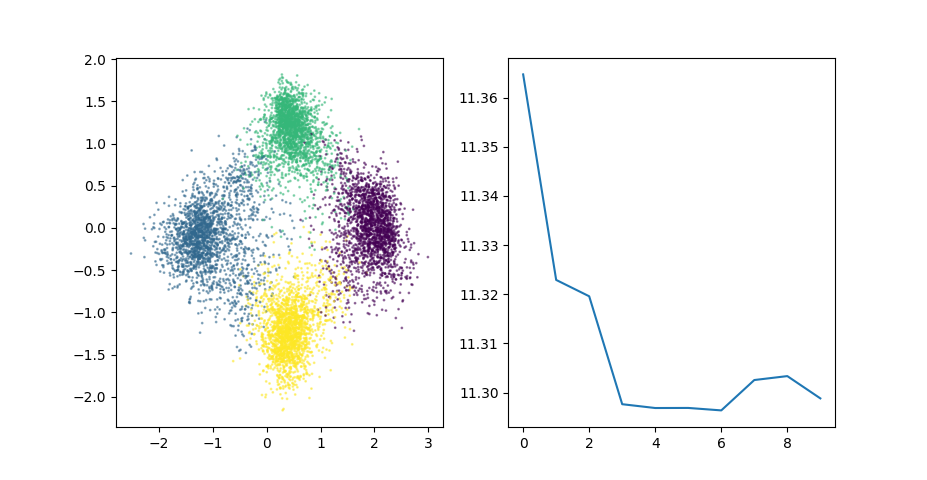

In [154]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
plt.tight_layout()

plt.subplot(1, 2, 1)
latent_dim = np.concatenate(sample_zs)
latent_labels = np.concatenate(sample_latent_labels)
plt.scatter(latent_dim[:, 0], latent_dim[:, 1], c=latent_labels, alpha=0.5, s=1)

plt.subplot(1, 2, 2)
plt.plot(np.log(elbo_record))

plt.show()

## Convolutional VAE

Now we can try and make a convolutional network out of this. We'll be using bits and pieces from the `convolutional_autoencoder` notebook.

In [20]:
def make_conv_encoder(x, batch_size, latent_dimension=2):
    x = tf.reshape(data, [batch_size, x.shape[1], 1])
    x = tf.layers.conv1d(x, 64, 3, strides=3, padding='SAME')
    x = tf.nn.elu(x)

    x = tf.layers.conv1d(x, 32, 3, strides=3, padding='SAME')
    x = tf.nn.elu(x)

    x = tf.layers.conv1d(x, 16, 3, strides=3, padding='VALID')
    x = tf.nn.elu(x)
    
    x = tf.reshape(x, [batch_size, -1]) # drop channel dimension
    
    encoder_net = tf.layers.dense(x, units=latent_dimension*2)
    
    loc = encoder_net[..., :latent_dimension]
    scale = tf.nn.softplus(encoder_net[..., latent_dimension:] + 0.5)

    return tfd.MultivariateNormalDiag(loc=loc,
            scale_diag=scale,
            name="encoder_distribution")
    

def make_conv_decoder(latent_code, batch_size, num_features, latent_dimension=2):
    x = tf.reshape(latent_code, [batch_size, 1, latent_dimension, 1])
    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=(1, 3),
        strides=(1, 3), padding='SAME')
    x = tf.nn.elu(x)
    x = tf.squeeze(x, [1])
    padding = tf.constant([[0, 0], [1, 0], [0, 0]])
    x = tf.pad(x, padding)

    x = tf.expand_dims(x, axis=1)
    x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=(1, 3),
        strides=(1, 3), padding='SAME')
    x = tf.nn.elu(x)
    x = tf.squeeze(x, [1])
    
    x = tf.expand_dims(x, axis=1)
    x = tf.layers.conv2d_transpose(x, filters=1, kernel_size=(1, 3),
        strides=(1, 3), padding='SAME')
    x = tf.nn.elu(x)
    x = tf.squeeze(x, [1])
    x = tf.pad(x, padding)

    x_hat = tf.reshape(x, [batch_size, -1])
    
    latent_code = tf.reshape(latent_code, [-1, batch_size, latent_dimension])
    x = tf.layers.dense(inputs=latent_code,
            units=128, activation=tf.nn.relu)
    x = tf.layers.dense(inputs=x,
             units=256, activation=tf.nn.relu)
    x = tf.layers.dense(inputs=x,
            units=512, activation=tf.nn.relu)
    
    decoder_net = tf.layers.dense(inputs=x,
            units=num_features, activation=None)    
    
    return tfd.Independent(tfd.Binomial(logits=decoder_net,
                            total_count=2.0),
                            reinterpreted_batch_ndims=1,
                            name="decoder_distribution")

In [21]:
conv_graph = tf.Graph()
with conv_graph.as_default():
    # input pipeline
    dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    dataset = dataset.batch(batch_size)
    iterator = dataset.make_initializable_iterator()
    (data, labels) = iterator.get_next()
    
    # inference network; encoder
    with tf.variable_scope('encoder'):
        encoder = make_conv_encoder(data, batch_size=batch_size,
                                    latent_dimension=d)
    
    latent_code = encoder.sample()

    # prior
    with tf.variable_scope('prior'):
        prior = make_prior(latent_dimension=d)

    # loss
    def joint_log_prob(z):
        with tf.variable_scope('decoder'):
            decoder = make_conv_decoder(z, batch_size=batch_size,
                                        latent_dimension=d, num_features=m)
        return decoder.log_prob(data) + prior.log_prob(z)
    
    elbo = tf.reduce_sum(
            tfp.vi.monte_carlo_csiszar_f_divergence(
                f=tfp.vi.kl_reverse,
                p_log_prob=joint_log_prob,
                q=encoder,
                num_draws=1))
    
    # optimizer
    optimizer = tf.train.AdamOptimizer(0.001).minimize(elbo)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [22]:
with tf.Session(graph=conv_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    conv_elbo_record = list()
    for epoch in range(epochs):
        sess.run(iterator.initializer)
        
        conv_sample_latent_codes = list()
        conv_sample_latent_labels = list()
        while True:
            try:
                _, epoch_elbo, epoch_latent_code, epoch_labels = sess.run([optimizer, elbo, latent_code, labels])
                conv_sample_latent_codes.append(epoch_latent_code)
                conv_sample_latent_labels.append(epoch_labels)
            except tf.errors.OutOfRangeError:
                conv_elbo_record.append(epoch_elbo)
                break

<IPython.core.display.Javascript object>


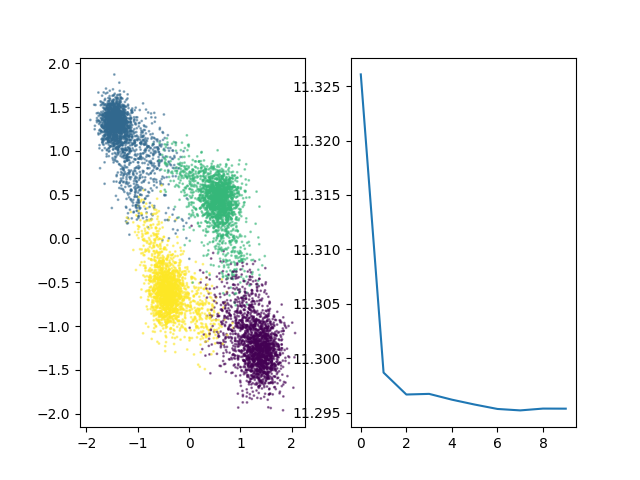

In [23]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
plt.tight_layout()

plt.subplot(1, 2, 1)
latent_dim = np.concatenate(sample_latent_codes)
latent_labels = np.concatenate(sample_latent_labels)
plt.scatter(latent_dim[:, 0], latent_dim[:, 1], c=latent_labels, alpha=0.5, s=1)

plt.subplot(1, 2, 2)
plt.plot(np.log(elbo_record))

plt.show()